In [1]:
# A main module to run various analysis with CFE model

# Import libraries
import os
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import spotpy

import sys
sys.path.append("G://Shared drives/Ryoko and Hilary/SMSigxModel/analysis/libs/cfe/py_cfe")
import cfe
import bmi_cfe

sys.path.append("G://Shared drives/Ryoko and Hilary/SMSigxModel/analysis/libs/SMSig")
from sig_seasontrans import SMSig

# Specify current directory create output directory if it does not exist
os.chdir("G://Shared drives/Ryoko and Hilary/SMSigxModel/analysis/5_GLUE_model")
os.getcwd()


'G:\\Shared drives\\Ryoko and Hilary\\SMSigxModel\\analysis\\5_GLUE_model'

In [3]:
in_path = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\analysis\6_out\Mahurangi\ws2_ex0.4\parameter_priori.xls"
config_temp = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\analysis\2_data_input\Mahurangi\parameters\config_cfe_0.json"
out_path = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\analysis\6_out\seasonsig_test"
i_run = 6

# Read parameters from excel sheet and create a config file
config_all_runs = pd.read_csv(in_path)
config_target_runs = config_all_runs.iloc[i_run]

with open(config_temp, 'r') as outfile:
    config_temp = json.load(outfile)

for i in range(len(config_target_runs)):
    if config_target_runs.index[i] in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        config_temp["soil_params"][config_target_runs.index[i]] = config_target_runs[i]
    else:
        config_temp[config_target_runs.index[i]] = config_target_runs[i]

with open(os.path.join(out_path, 'config_CFE.json'), 'w') as out_file:
    json.dump(config_temp, out_file)

# Run the CFE based on the config file
cfe_instance = bmi_cfe.BMI_CFE(os.path.join(out_path, 'config_CFE.json'))
cfe_instance.initialize()
sim0 = cfe_instance.run_unit_test(plot=False, warm_up=True)
obs0 = cfe_instance.load_unit_test_data()

# Get the results
var_name = 'Soil Moisture Content'
sim = sim0[["Time", var_name]].copy()
sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d %H:%M:%S")  # Works specifically for CFE

# Get the comparison data
obs = obs0[["Time", var_name]].copy()
obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
# obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

# Merge observed and simulated timeseries
df = pd.merge_asof(sim, obs, on="Time")

sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()
sim_synced[var_name] = df[var_name + "_x"].copy()
obs_synced[var_name] = df[var_name + "_y"].copy()

# Evaluate using seasonal soil moisture signature
sig_obs = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=obs_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="obs"
)
# sig_obs.detrend() # TODO:debug
sig_obs.movmean()
t_valley = sig_obs.calc_sinecurve()
season_trans_obs, start_dates_obs, end_dates_obs = sig_obs.calc_seasontrans(t_valley=t_valley)

sig_sim = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=sim_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="sim"
)
sig_sim.movmean()
season_trans_sim, start_dates_sim, end_dates_sim = sig_sim.calc_seasontrans(t_valley=t_valley)

# Get the deviations in seasonal transition dates between simulated and observed timeseries
diff = season_trans_sim - season_trans_obs
metric_value = abs(np.nanmean(diff, axis=0))
print(diff)
print(metric_value)



[[        nan         nan 16.63425932 35.00356055]
 [19.3703779  -7.99214801 23.20555206 28.05456564]
 [18.78761743 18.69137984  4.60093371 44.69726568]
 [        nan         nan         nan         nan]
 [        nan         nan         nan         nan]]
[19.07899767  5.34961592 14.8135817  35.91846396]


In [25]:
result_run = pd.read_csv(r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\analysis\6_out\Mahurangi\ws2_ex0.4\evaluations.xls")
result_run.head()

,Unnamed: 0,KGE on Flow,KGE on Soil Moisture Content,season_transition_dry2wet_s,season_transition_dry2wet_e,season_transition_wet2dry_s,season_transition_wet2dry_e
0,0,0.590231,0.635979,12.270570,28.128731,18.603654,0.345400
1,1,0.565222,0.583639,10.499610,17.108997,15.840759,35.207061
2,2,0.575150,0.550752,8.440500,23.426065,11.333597,30.974459
3,3,0.700024,0.059395,10.066578,4.123011,15.409693,37.978466
4,4,0.876575,0.847321,9.856901,25.451436,19.366933,2.328929


In [27]:
KGESM_for_the_run = result_run['KGE on Soil Moisture Content'][i_run]

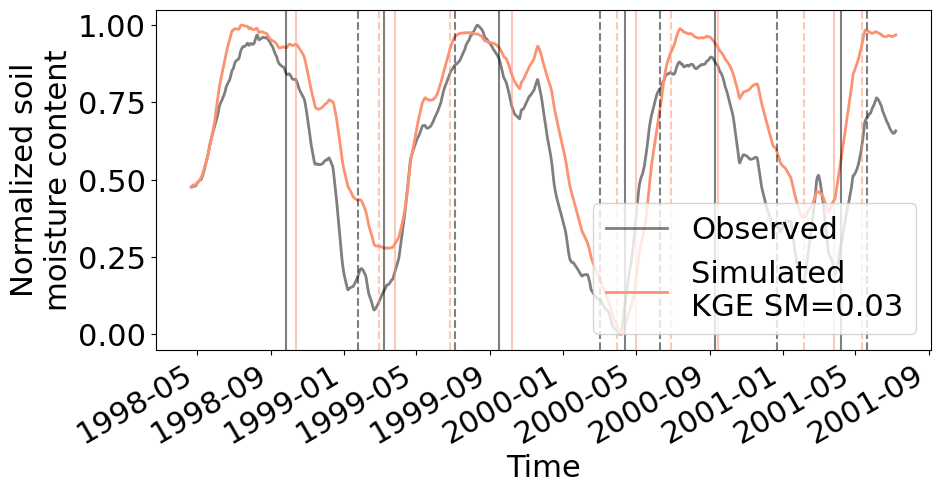

In [29]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(10, 5))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = (sig_obs.tt.values-min(sig_obs.tt.values))/(max(sig_obs.tt.values)-min(sig_obs.tt.values))
x_sim = sig_sim.tt.index
y_sim = (sig_sim.tt.values-min(sig_sim.tt.values))/(max(sig_sim.tt.values)-min(sig_sim.tt.values))
xlim_start = 60
xlim_end = len(x_obs)-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Normalized soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right')
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')
